# testing on Fourier Transform implementation

regardless of the linear regressor used, the fourier transform has also some important points that need to be checked in order to convince ourselves.

Here we test:
* aliasing test 1: check how signals are seen for frequencies higher than nyquist limit
* aliasing test 2: check that aliasing is not random for a configuration.
* aliasing test 3: check that a smal signal under noise can be identify even with aliasing.
* grid test 1: check that frequency grid doesnt have to be neccessary from 0 to nyquist limit.
* grid test 2: check that change samplig rate of frequnecy grid still finds the signal


All the current test are going to be performed with cosine signals at given frequencies. Also we set the regressor to use Stochastic Gradient Descent, with a fixed configuration that we know works for this kind of signals given an almost complete reconstruction (R2 is close to 1, this is the case of overfit).

In [5]:
# imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../")
from mfilter.regressions import * #regression objects
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples # samples objects
from mfilter.transform.transform import FourierTransform, Regression, FFT # transform objects

In [42]:
# global var
reg = SGDRegression(alpha=1e-4, max_iter=1000, penalty="elasticnet", l1_ratio=0.5, tol=0.001)
times1 = TimesSamples(np.linspace(0, int(1e6), int(1e3)))
fs1 = times1.average_fs
nyq1 = fs1/2
print(fs1/2)


0.0005


### Aliasing test 1
check how a signal  behave on frequency space when we sampleng at a nyquist limit lower than the frequency of the signal.
For this we use a cosine of a frequency higher than nyquist limit and check how is the transform (using Regression and FFT, so we use regular sampling)

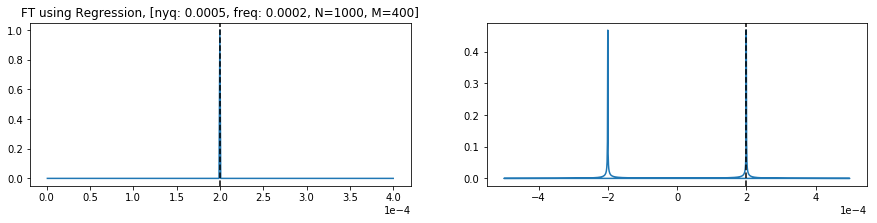

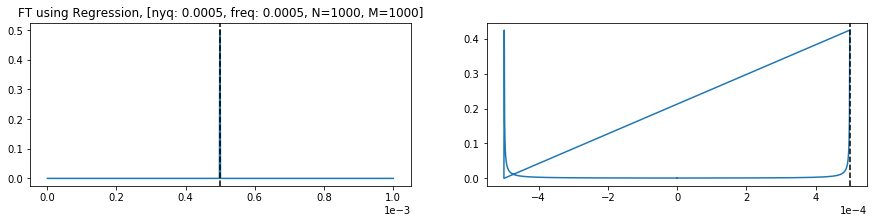

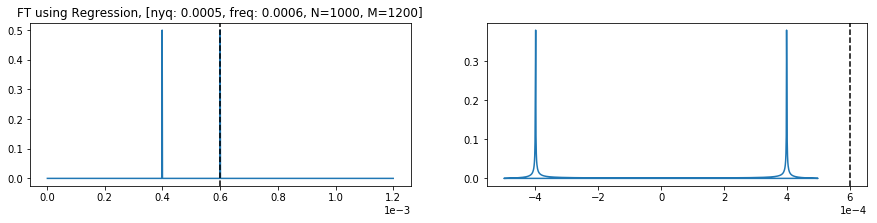

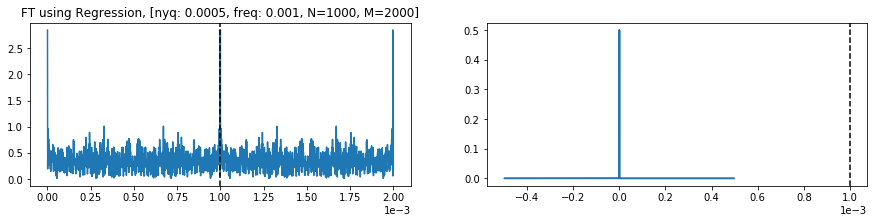

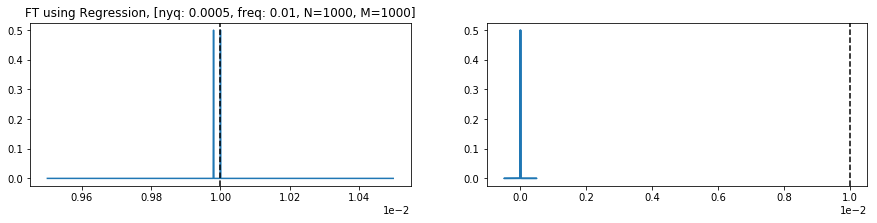

In [43]:
def create_at1(times, freq):
    return TimeSeries(np.cos(2 * np.pi * freq * times), times=times)

def grid_at1(times, freq, max_freq=None, min_freq=None):
    if max_freq is None:
        max_freq = 2 * freq
    if min_freq is None:
        min_freq = 1 / times.duration
    return FrequencySamples(input_time=times, minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=1)

def reg_transform_at1(times, freq, data, max_freq=None, min_freq=None):
    grid = grid_at1(times, freq, max_freq=max_freq, min_freq=min_freq)
    tr = Regression(reg=reg,freq=grid)
    return data.to_frequencyseries(tr), tr.get_frequency()

def fft_transform_at1(times, freq, data):
    tr = FFT(times)
    return data.to_frequencyseries(tr), tr.get_frequency(N=len(times))

def at1(times, freq, max_freq=None, min_freq=None):
    data = create_at1(times, freq)
    ft1, freqs1 = reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)
    ft2, freqs2 = fft_transform_at1(times, freq, data)
#     ft1 *= len(times) / len(freqs1)
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 3))
    ax1.plot(freqs1, abs(ft1))
    ax1.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
    ax2.ticklabel_format(axis='x',style='sci',scilimits=(0,0))
    ax2.plot(freqs2, abs(ft2)/len(times))
    ax1.axvline(freq, color="k", linestyle='--')
    ax2.axvline(freq, color="k", linestyle='--')
    ax1.set_title("FT using Regression, [nyq: {}, freq: {}, N={}, M={}]".format(nyq1, freq, len(times), len(freqs1)))
    
at1(times1, 0.0002)
at1(times1, 0.0005)
at1(times1, 0.0006)
at1(times1, 0.001)
# N/2 * df = 0.01 -> N = 0.02 / df

df = 1/times1.duration
N = len(times1)
at1(times1, 0.01, min_freq=0.01 - (N//2)*df, max_freq=0.01 + (N//2 - 1)*df)

# lets use an freq < nyq but a samplig grid of a freq > nyq
# at1(times1, 0.0002, max_freq=0.02)

#### Analysis
Vemos claramente que introducir frequencias mayor al limite de kyquist introduce un aliasing en los datos,
ademas, vemos que usar un grid de frequencias demasiado grande (M > N) produce problemas en la regression
introduciendo errores que afectan a la reconstruccion de la señal y muy posiblemente afecten al matched filter.
En si, la opcion mas saludable es, conociendo el rango de frequencias de interes, generar un grid personalizado en torno 
a estas frequencias con un numero de muestrar similar al numero de muestras en el tiempo (N = M)

Por otro lado, comparando los resultados de usar Regression y FFT, se observa que las FFT recurren a bandpassing u otro metodo que les permite obtener informacion relevante pero desde otro origne, esto se ve claramente por el hecho de que detecta señal a una cierta frecuencia, pero esta deteccion no es directamente nuestra frequencia original.

### Aliasing test 2:
Here we check that, for a higher frequency than nyquist limit, the aliasing produced is not entirely random, and for same configuration, our method give the same aliased result.
We use again a simple cosine of frequenchy higher than nyquist limit.

ABS: median fraction of error over first copy is:  0.5191340438053681 +- 0.02392540570735304
and score is:  0.9999999966324209 +- 6.917143817760343e-11
REAL: median fraction of error over first copy is:  302.69331139883315 +- 566.4023546937085
and score is:  0.9999999966103962 +- 1.1390371032933316e-10
IMAG: median fraction of error over first copy is:  1671.6577465488947 +- 1745.9668675854216
and score is:  0.9999999966732706 +- 9.414885048998289e-11


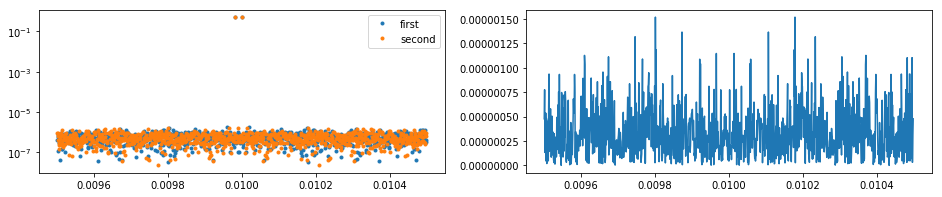

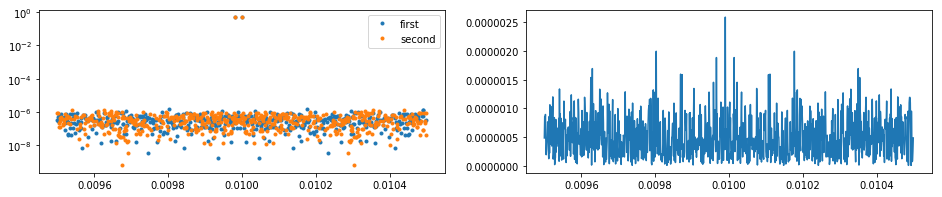

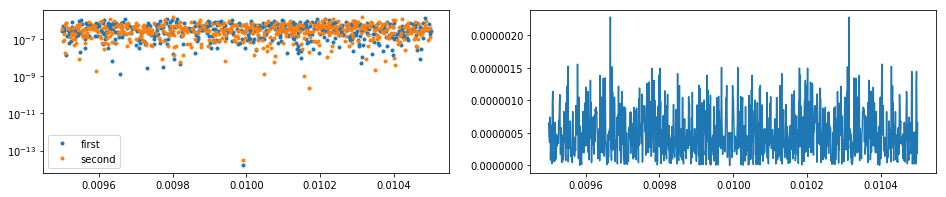

In [12]:
def create_at2(times, freq):
    return create_at1(times, freq)

def grid_at2(times, freq, max_freq=None, min_freq=None):
    return grid_at1(times, freq, max_freq=max_freq, min_freq=min_req)

def reg_transform_at2(times, freq, data, max_freq=None, min_freq=None):
    return reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)

def fft_transform_at2(times, freq, data):
    return fft_transform_at1(times, freq, data)

def at2(times, freq, max_freq=None, min_freq=None):
    data = create_at2(times, freq)
    ft1, freqs1 = reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)
    ft2, freqs2 = fft_transform_at1(times, freq, data)
    
    # copy the data to be sure
    copy1 = np.copy(ft1.value)
    cpf1 = np.copy(freqs1.value)
    score1 = reg.score(data)
    
    # and repeat
    ft1, freqs1 = reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)
    ft2, freqs2 = fft_transform_at1(times, freq, data)
    
    # finaly copy again
    copy2 = np.copy(ft1.value)
    cpf2 = np.copy(freqs1.value)
    score2 = reg.score(data)
    
    # and check if copy1==copy2 in absolute value, real value and imag value
    for v1, v2, t in zip([np.abs(copy1), np.real(copy1), np.imag(copy1)], 
                         [np.abs(copy2), np.real(copy2), np.imag(copy2)], 
                         ["ABS", "REAL", "IMAG"]):
    
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=False)
        ax1.semilogy(cpf1, v1, '.', label="first")
        ax1.semilogy(cpf2, v2, '.', label="second")
        ax1.legend()
        ax2.plot(cpf1, abs(v1 - v2))
        
        # get mean value
        fractions = []
        scores1 = []
        scores2 = []
        for i in range(10):
            ft1, freqs1 = reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)
            copy1 = np.copy(ft1.value)
            score1 = reg.score(data)
            
            ft1, freqs1 = reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)
            copy2 = np.copy(ft1.value)
            score2 = reg.score(data)
            if t == "ABS":
                tmp = abs(np.abs(copy1) - np.abs(copy2))
                tmp2 = np.abs(copy1)
            elif t == "REAL":
                tmp = abs(np.real(copy1) - np.real(copy2))
                tmp2 = np.real(copy1)
            else:
                tmp = abs(np.imag(copy1) - np.imag(copy2))
                tmp2 = np.imag(copy2)
                
            fractions.append(np.median(tmp) / np.abs(np.median(tmp2)))
            scores1.append(score1)
            scores2.append(score2)
            
        
        print(t + ": median fraction of error over first copy is: ", np.mean(fractions), "+-", np.std(fractions))
        print("and score is: ", np.mean(scores1), "+-", np.std(scores1))
    
df = 1/times1.duration
N = len(times1)
at2(times1, 0.01, min_freq=0.01 - (N//2)*df, max_freq=0.01 + (N//2 - 1)*df)

#### Analysis

Observamos que los valores jamas coinciden perfectamente debido a que estamos utilizando un metodo iterativo para aproximar la transformada de fourier por medio de regresiones. En valor medio, la razon entre las diferencias de dos calculos sobre la misma señal utilizando la misma configuracion es 0.5 +- 0.02, esto es algo bastante grande y nos sugiere que tal vez para señales de un ruido muy alto, este factor "aleatorio" pueda jugar un papel importante.

Ademas, observamos que el error es mas fuerta por parte real e imaginaria, peor en valor absoluto este error disminuye considerablemente.

### Aliasing test 3:
   if we create a signal with a very high relative noise, his spectrum will be affected by this on high frequencies. Then, if we use a signal of a high frequency (relative to nyquist limit) such that produce aliasing, we need to check that this aliasing does not affect the detection of the signal. This means, we still identify (visualy) a peak at the correct frequency.
   
   We again use a coside signal with frequency higher than nyquist limit with a custom frequency grid.

R2 score is:  0.9999999966235243 (noise lvl of: 0)
R2 score is:  0.9978637582832569 (noise lvl of: 1)
R2 score is:  0.9997476339434549 (noise lvl of: 2)
R2 score is:  0.9988398547709525 (noise lvl of: 4)
R2 score is:  0.9998695265797195 (noise lvl of: 6)
R2 score is:  0.9990467547284522 (noise lvl of: 10)


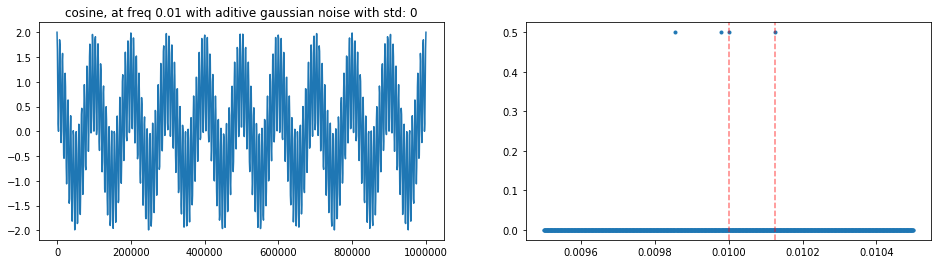

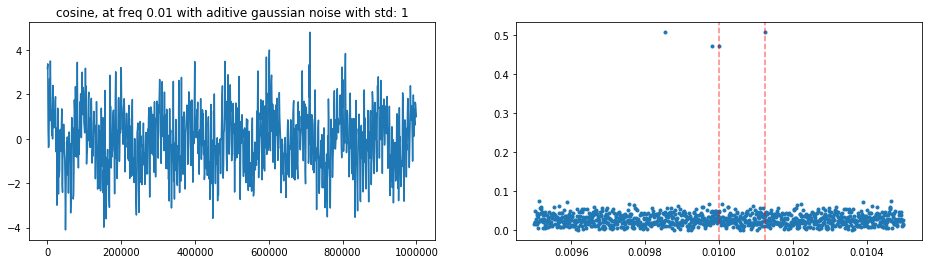

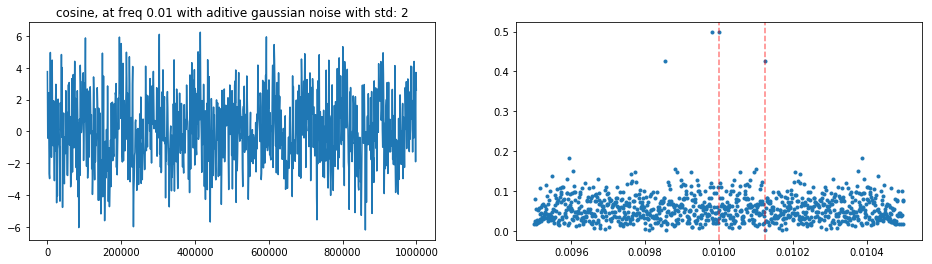

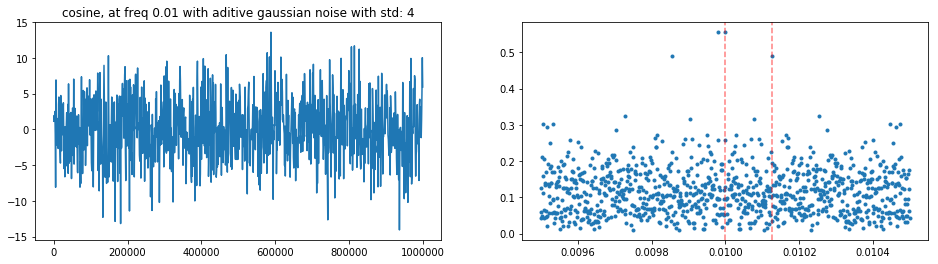

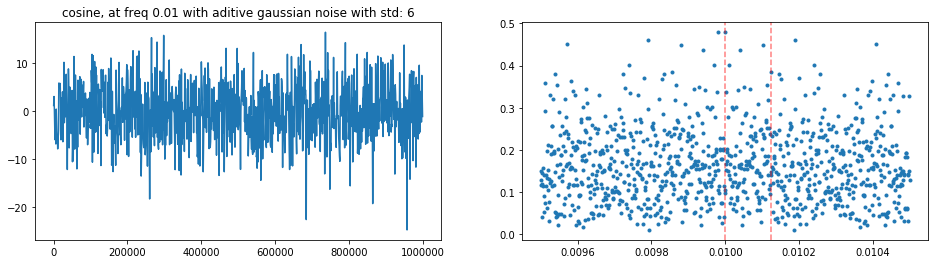

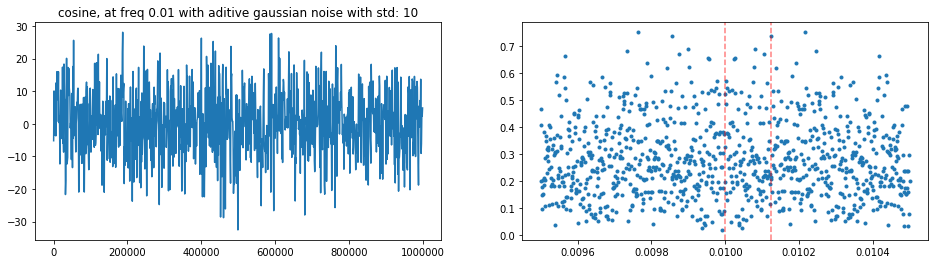

In [41]:
def create_at3(times, freq, noise_lvl=1):
    return TimeSeries(np.cos(2 * np.pi * freq * times) 
                      + np.cos(2 * np.pi * (freq + (N//8)*df) * times)
                      + np.random.normal(0, noise_lvl, len(times)), times=times)

def grid_at3(times, freq, max_freq=None, min_freq=None):
    return grid_at1(times, freq, max_freq=max_freq, min_freq=min_req)

def reg_transform_at3(times, freq, data, max_freq=None, min_freq=None):
    return reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)

def fft_transform_at3(times, freq, data):
    return fft_transform_at1(times, freq, data)

def at3(times, freq, max_freq=None, min_freq=None, noise_lvl=1):
    data = create_at3(times, freq, noise_lvl=noise_lvl)
    ft1, freqs1 = reg_transform_at1(times, freq, data, max_freq=max_freq, min_freq=min_freq)
    ft2, freqs2 = fft_transform_at1(times, freq, data)
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
    ax1.plot(times, data, label="data")
    ax2.plot(freqs1, abs(ft1), '.', label="Spectrum")
    ax2.axvline(freq, color="r", linestyle="--", alpha=0.5)
    ax2.axvline(freq + (N//8)*df, color="r", linestyle="--", alpha=0.5)
    ax1.set_title("cosine, at freq {} with aditive gaussian noise with std: {}".format(freq, noise_lvl))
    print("R2 score is: ", reg.score(data), "(noise lvl of: {})".format(noise_lvl))
    

df = 1/times1.duration
N = len(times1)
ff = 0.01
at3(times1, ff, min_freq=ff - (N//2)*df, max_freq=ff + (N//2 - 1)*df, noise_lvl=0)
at3(times1, ff, min_freq=ff - (N//2)*df, max_freq=ff + (N//2 - 1)*df, noise_lvl=1)
at3(times1, ff, min_freq=ff - (N//2)*df, max_freq=ff + (N//2 - 1)*df, noise_lvl=2)
at3(times1, ff, min_freq=ff - (N//2)*df, max_freq=ff + (N//2 - 1)*df, noise_lvl=4)
at3(times1, ff, min_freq=ff - (N//2)*df, max_freq=ff + (N//2 - 1)*df, noise_lvl=6)
at3(times1, ff, min_freq=ff - (N//2)*df, max_freq=ff + (N//2 - 1)*df, noise_lvl=10)

#### Analysis

At simple sight, the method can identify clearly a signal with noise standard deviation of at most 4 times the signal maximum amplitude. This of course, is the best case considering a simple signal, with regular sampling, with white gaussian noise, it's necessary to explore this behavior more widely to get a better result.

Also, too high noise can affect the normalization of the fourier transform, given higher values.